# CycleGAN

## Set up the input pipeline

In [1]:
import tensorflow as tf

2024-07-17 02:30:12.502848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 02:30:12.524262: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 02:30:12.529946: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-17 02:30:12.542284: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

## Input Pipeline

This tutorial trains a model to translate from images of horses, to images of zebras. You can find this dataset and similar ones [here](https://www.tensorflow.org/datasets/catalog/cycle_gan). 

As mentioned in the [paper](https://arxiv.org/abs/1703.10593), apply random jittering and mirroring to the training dataset. These are some of the image augmentation techniques that avoids overfitting.

This is similar to what was done in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#load_the_dataset)

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`.
* In random mirroring, the image is randomly flipped horizontally i.e., left to right.

In [3]:
# train_A = tf.data.Dataset.list_files(str('../Dataset/MRI_train/*'), shuffle=False)
# train_B = tf.data.Dataset.list_files(str('../Dataset/CT_train/*'), shuffle=False)
test_A  = tf.data.Dataset.list_files(str('../Dataset/MRI_test/*'), shuffle=False)
test_B  = tf.data.Dataset.list_files(str('../Dataset/CT_test/*'), shuffle=False)

train_A = tf.data.Dataset.list_files(str('../Dataset/MRI_all/*'), shuffle=False)
train_B = tf.data.Dataset.list_files(str('../Dataset/CT_all/*'), shuffle=False)


I0000 00:00:1721183414.146189   62105 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721183414.150241   62105 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721183414.150277   62105 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721183414.152790   62105 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721183414.152863   62105 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [4]:
# dataset = load_image_dataset('dataset/')


def load_images(path):
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image, channels=3)
    label = tf.strings.split(path, os.path.sep)[-2]
    return image, label

train_mri = train_A.map(load_images)
train_ct = train_B.map(load_images)
test_mri  = test_A.map(load_images)
test_ct  = test_B.map(load_images)

In [5]:
BUFFER_SIZE = 1000
BATCH_SIZE  = 1
IMG_WIDTH   = 256
IMG_HEIGHT  = 256
CHANNELS    = 1

In [6]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, CHANNELS])

  return cropped_image

In [7]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [8]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [9]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [10]:
def preprocess_image_test(image, label):
  image = tf.image.resize(image, [256, 256],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = normalize(image)
  return image

In [11]:
train_mri = train_mri.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_ct = train_ct.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_mri = test_mri.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_ct = test_ct.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
sample_MRI = iter(train_mri)
sample_CT = iter(train_ct)
sample_MRI = next(iter(train_mri))
sample_CT = next(iter(train_ct))

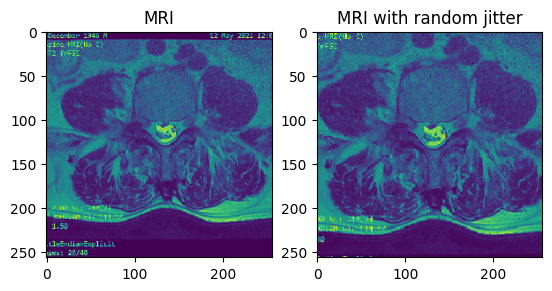

In [13]:
plt.subplot(121)
plt.title('MRI')
plt.imshow(sample_MRI[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('MRI with random jitter')
plt.imshow(random_jitter(sample_MRI[0]) * 0.5 + 0.5)

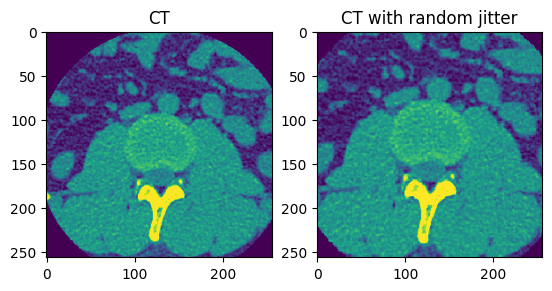

In [14]:
plt.subplot(121)
plt.title('CT')
plt.imshow(sample_CT[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('CT with random jitter')
plt.imshow(random_jitter(sample_CT[0]) * 0.5 + 0.5)

## Import and reuse the Pix2Pix models

In [15]:
def downsample(filters, size, norm_type='batchnorm', apply_norm=True):

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [16]:
norm_type='batchnorm'
down_stack_origin = [
    downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
    downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
    downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
    downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
    downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
    downsample(512, 4, norm_type),  # (bs, 4, 4, 512)
    downsample(512, 4, norm_type),  # (bs, 2, 2, 512)
    downsample(512, 4, norm_type),  # (bs, 1, 1, 512)
]
up_stack_origin = [
    upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
    upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
    upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
    upsample(512, 4, norm_type),  # (bs, 16, 16, 1024)
    upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
    upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
    upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
]

down_stack_light = [
    downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
    downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
    downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
    downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
    downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
]

up_stack_light = [
    upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
    upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
    upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
    upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
]

down_stack_test = [
    downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
    downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
    downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
    downsample(256, 4, norm_type),  # (bs, 16, 16, 512)
    downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
    downsample(512, 4, norm_type),  # (bs, 4, 4, 512)
    downsample(512, 4, norm_type),  # (bs, 2, 2, 512)
    downsample(512, 4, norm_type),  # (bs, 1, 1, 512)
]
up_stack_test = [
    upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
    upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
    upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
    upsample(256, 4, norm_type),  # (bs, 16, 16, 1024)
    upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
    upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
    upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
]

In [17]:
def unet_generator(output_channels, norm_type='batchnorm'):

  down_stack = down_stack_origin

  up_stack = up_stack_origin


  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None, None, CHANNELS])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

class InstanceNormalization(tf.keras.layers.Layer):

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

In [18]:
def discriminator(norm_type='batchnorm', target=True):

  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, CHANNELS], name='input_image')
  x = inp

  if target:
    tar = tf.keras.layers.Input(shape=[None, None, CHANNELS], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4, norm_type)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4, norm_type)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  if norm_type.lower() == 'batchnorm':
    norm1 = tf.keras.layers.BatchNormalization()(conv)
  elif norm_type.lower() == 'instancenorm':
    norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(
      1, 4, strides=1,
      kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)

In [19]:
OUTPUT_CHANNELS = CHANNELS

# generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = discriminator(norm_type='instancenorm', target=False)
discriminator_y = discriminator(norm_type='instancenorm', target=False)

2024-07-17 02:30:17.731256: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
W0000 00:00:1721183417.789943   62105 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721183417.803404   62105 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721183417.803915   62105 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721183417.804387   62105 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721183417.804853   62105 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721183417.809939   62105 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721183417.811096   62105 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721183417.819583   62105 gpu_t

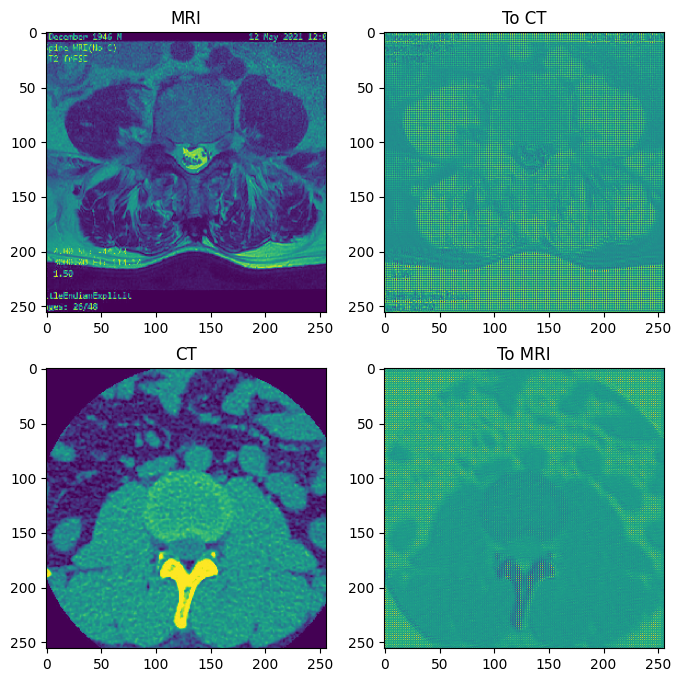

In [20]:
to_CT = generator_g(sample_MRI)
to_MRI = generator_f(sample_CT)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_MRI, to_CT, sample_CT, to_MRI]
title = ['MRI', 'To CT', 'CT', 'To MRI']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

W0000 00:00:1721183419.359612   62105 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721183419.360283   62105 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721183419.360834   62105 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721183419.361350   62105 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721183419.361870   62105 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721183419.362456   62105 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721183419.362983   62105 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721183419.363598   62105 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721183419.364127   62105 gp

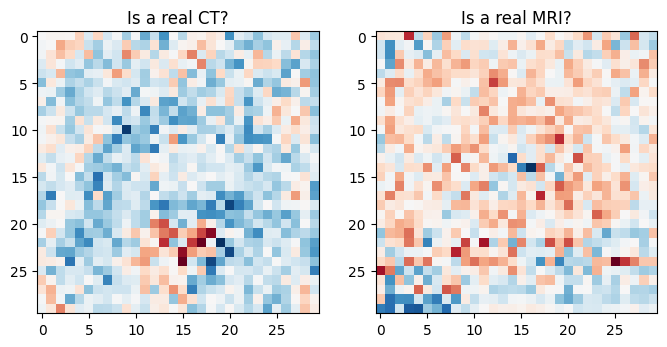

In [21]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real CT?')
plt.imshow(discriminator_y(sample_CT)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real MRI?')
plt.imshow(discriminator_x(sample_MRI)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss functions

In [22]:
LAMBDA = 10

In [23]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [24]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [25]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [26]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [27]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Initialize the optimizers for all the generators and the discriminators.

In [28]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [29]:
checkpoint_path = "./checkpoints/train_custom2"
# checkpoint_path = "./checkpoints/train_light"

In [30]:

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## Training


In [36]:
def generate_images(model, test_input, filename):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
    plt.axis('off')
  plt.savefig(f'{filename}.png', bbox_inches='tight')
  plt.show()

Even though the training loop looks complicated, it consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [37]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y   = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x  = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
  
  return total_gen_g_loss, total_gen_f_loss# , generator_g_gradients, generator_f_gradients, discriminator_x_gradients, discriminator_y_gradients

In [38]:
EPOCHS = 1000

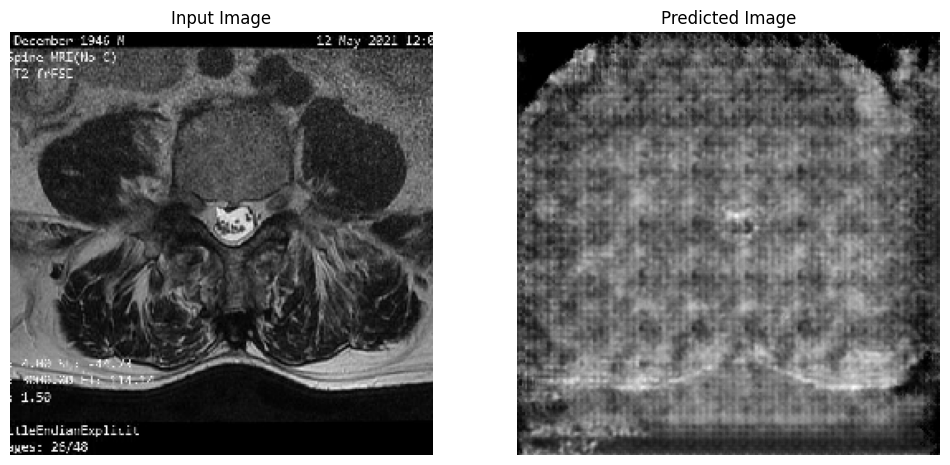

Time taken for epoch 121 is 86.60686039924622 sec

............

KeyboardInterrupt: 

In [41]:
generate_images(generator_g, sample_MRI, "First Try")

for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_mri, train_ct)):
    gen_g_loss, gen_f_loss = train_step(image_x, image_y)
    
    f = open("demofile2.txt", "a")
    f.write(f"""gen_g_loss : {gen_g_loss.numpy()}\n 
                gen_f_loss : {gen_f_loss.numpy()}\n
                
                """)

    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_MRI) so that the progress of the model
  # is clearly visible.
  filename = f"Epoch {epoch}"
  generate_images(generator_g, sample_MRI, filename)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

## Generate using test dataset

In [ ]:
train_mri
test_mri

In [ ]:
# Run the trained model on the test dataset
for inp in test_mri.take(5):
  generate_images(generator_g, inp)

## Next steps

This tutorial has shown how to implement CycleGAN starting from the generator and discriminator implemented in the [Pix2Pix](https://www.tensorflow.org/tutorials/generative/pix2pix) tutorial. As a next step, you could try using a different dataset from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/cycle_gan). 

You could also train for a larger number of epochs to improve the results, or you could implement the modified ResNet generator used in the [paper](https://arxiv.org/abs/1703.10593) instead of the U-Net generator used here.